In [76]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import f1_score
import torch.nn.functional as F
import json
from glob import glob
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
class SquatRepDataset(Dataset):
    def __init__(self, data_list, label_list):
        self.data_list = data_list  # list of dicts like the one you provided
        self.label_list = label_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        data = self.data_list[idx]
        sequence = torch.tensor([
            data["knee_angle"],
            data["torso_angle"],
            data["hip_angle"],
            data["symmetry_score"],
            data["alignment_score"],
            data["head_angle"],
            data["inter_thigh_angle"],
            data["heel_angle"],
            data["back_angle"]
        ], dtype=torch.float).T  # shape: [seq_len, num_features]

        label = torch.tensor(self.label_list[idx], dtype=torch.long)
        return sequence, label


In [77]:
class PureConvClassifier(nn.Module):
    def __init__(self, in_ch=9, conv_ch=[64,128,256], kernel=3, num_classes=6):
        super().__init__()
        layers = []
        prev = in_ch
        for ch in conv_ch:
            layers += [
                nn.Conv1d(prev, ch, kernel, padding=kernel//2),
                nn.BatchNorm1d(ch),
                nn.ReLU(),
                nn.MaxPool1d(2)
            ]
            prev = ch
        self.net = nn.Sequential(*layers)
        self.global_pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(prev, prev//2)
        self.fc2 = nn.Linear(prev//2, num_classes)
        
    def forward(self, x_packed):
        x, lengths = nn.utils.rnn.pad_packed_sequence(x_packed, batch_first=True)
        x = x.transpose(1,2)              
        x = self.net(x)                   
        x = self.global_pool(x).squeeze(2) 
        x = F.relu(self.fc1(x))
        return self.fc2(x)              


In [78]:
class BidirectionalLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=2, dropout=0.2):

        super(BidirectionalLSTMClassifier, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = 2  
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        
        self.attention = nn.Linear(hidden_size * 2, 1)
        
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def attention_net(self, lstm_output):
 
        attention_weights = F.softmax(self.attention(lstm_output), dim=1)
        
        context = torch.sum(attention_weights * lstm_output, dim=1)
        
        return context
    
    def forward(self, x_packed):

        lstm_output, _ = self.lstm(x_packed)
        
        lstm_output_unpacked, lengths = nn.utils.rnn.pad_packed_sequence(lstm_output, batch_first=True)
        
        context = self.attention_net(lstm_output_unpacked)
        
        out = F.relu(self.fc1(self.dropout(context)))
        out = self.fc2(out)
        
        return out

In [79]:


def squat_collate_fn(batch):
    sequences, labels = zip(*batch)
    lengths = torch.tensor([seq.shape[0] for seq in sequences])  
    padded_sequences = pad_sequence(sequences, batch_first=True)
    labels = torch.stack(labels)
    return padded_sequences, lengths, labels



bad_data_list=glob('temp_data/*')
future = (bad_data_list)
bad_list_new_list=[]
labels_list=[]
for i in range(len(bad_data_list)):
    bad_list_new_list.extend(glob(bad_data_list[i]+'/*.json'))
    one_hot=[0]*6
    one_hot[i]=1
    # print(one_hot)
    for i in range(len(glob(bad_data_list[i]+'/*.json'))):
        labels_list.append(one_hot)
    # break
# print(labels_list[:2])

bad_data_list_new=[json.load(open(file)) for file in bad_list_new_list]
# print(bad_list_new_list[0])
with open(bad_list_new_list[0]) as f:
    data = json.load(f)
# print(data[1])
bad_data_list_new_actual=[]
label_list_actual=[]
for i in bad_data_list_new:
    for k in range(len(i)):
        label_list_actual.append(labels_list[bad_data_list_new.index(i)])
    for j in i:
        bad_data_list_new_actual.append(j)
bad_data_list=bad_data_list_new_actual
bad_label_list=label_list_actual


device = "cuda" if torch.cuda.is_available() else "cpu"
    


from torch.utils.data import random_split, DataLoader

dataset = SquatRepDataset(bad_data_list, bad_label_list)

train_size = int(0.8 * len(dataset))
val_size   = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=squat_collate_fn
)
val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=squat_collate_fn
)




Epoch   1 | Train Loss: 0.4376 | Val Loss: 0.4198 | F1: 0.146 | Precision: 0.243 | Recall: 0.111
  ↳ New best model saved (val_loss = 0.4198)

Epoch   2 | Train Loss: 0.3890 | Val Loss: 0.3726 | F1: 0.335 | Precision: 0.506 | Recall: 0.281
  ↳ New best model saved (val_loss = 0.3726)

Epoch   3 | Train Loss: 0.3404 | Val Loss: 0.3476 | F1: 0.355 | Precision: 0.490 | Recall: 0.302
  ↳ New best model saved (val_loss = 0.3476)

Epoch   4 | Train Loss: 0.3103 | Val Loss: 0.3718 | F1: 0.354 | Precision: 0.628 | Recall: 0.349
Epoch   5 | Train Loss: 0.2913 | Val Loss: 0.3252 | F1: 0.459 | Precision: 0.540 | Recall: 0.445
  ↳ New best model saved (val_loss = 0.3252)

Epoch   6 | Train Loss: 0.2603 | Val Loss: 0.2707 | F1: 0.576 | Precision: 0.775 | Recall: 0.482
  ↳ New best model saved (val_loss = 0.2707)

Epoch   7 | Train Loss: 0.2240 | Val Loss: 0.2922 | F1: 0.570 | Precision: 0.759 | Recall: 0.482
Epoch   8 | Train Loss: 0.2037 | Val Loss: 0.2758 | F1: 0.628 | Precision: 0.776 | Recall: 

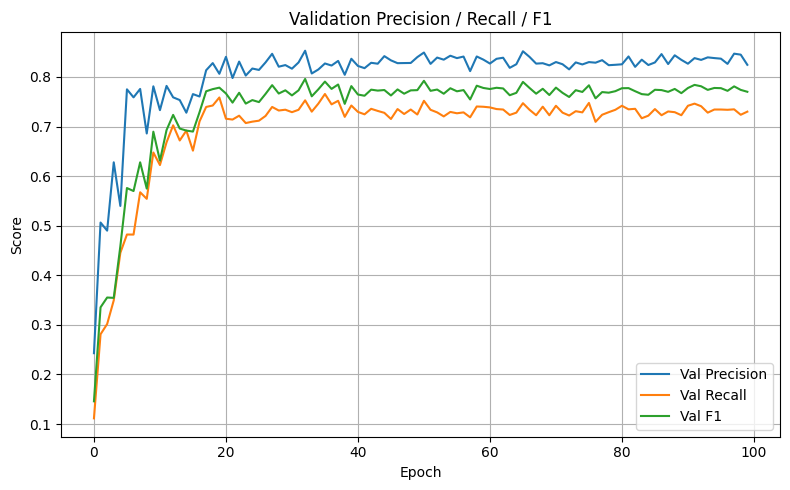

In [81]:

# model = BidirectionalLSTMClassifier(input_size=6 , hidden_size=64 , num_classes=6).to(device)
model     = PureConvClassifier().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

best_val_loss = float('inf')
num_epochs    = 100

train_losses, val_losses = [], []
val_f1s, val_precs, val_recs = [], [], []

for epoch in range(1, num_epochs+1):
    model.train()
    running_train_loss = 0.0
    for X_batch, lengths, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).float()
        optimizer.zero_grad()

        packed  = nn.utils.rnn.pack_padded_sequence(
                      X_batch, lengths, batch_first=True, enforce_sorted=False
                  )
        logits  = model(packed)
        loss    = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    running_val_loss = 0.0
    all_preds, all_targets = [], []

    with torch.no_grad():
        for X_batch, lengths, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).float()

            packed = nn.utils.rnn.pack_padded_sequence(
                         X_batch, lengths, batch_first=True, enforce_sorted=False
                     )
            logits = model(packed)
            running_val_loss += criterion(logits, y_batch).item()

            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).long()

            all_preds.append(preds.cpu())
            all_targets.append(y_batch.cpu().long())

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    all_preds   = torch.cat(all_preds, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    val_f1   = f1_score(all_targets, all_preds, average='macro')
    val_prec = precision_score(all_targets, all_preds, average='macro', zero_division=0)
    val_rec  = recall_score(all_targets, all_preds, average='macro', zero_division=0)

    val_f1s.append(val_f1)
    val_precs.append(val_prec)
    val_recs.append(val_rec)

    print(
        f"Epoch {epoch:3d} | "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Val Loss: {avg_val_loss:.4f} | "
        f"F1: {val_f1:.3f} | "
        f"Precision: {val_prec:.3f} | "
        f"Recall: {val_rec:.3f}"
    )

    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"  ↳ New best model saved (val_loss = {avg_val_loss:.4f})\n")

plt.figure(figsize=(8,5))
plt.plot(val_precs, label='Val Precision')
plt.plot(val_recs,  label='Val Recall')
plt.plot(val_f1s,   label='Val F1')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Validation Precision / Recall / F1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
pedofile = json.load(open("rep_metrics.json"))
actual_list = []
for j in pedofile:
    actual_list.append(j)
pedo_input = [torch.tensor([
            data["knee_angle"],
            data["torso_angle"],
            data["hip_angle"],
            data["symmetry_score"],
            data["alignment_score"],
            data["head_angle"],
            data["inter_thigh_angle"],
            data["heel_angle"],
            data["back_angle"]
        ], dtype=torch.float).T  
        for data in actual_list]

In [ ]:
model.eval()
with torch.no_grad():
    for seq in pedo_input:
        seq = seq.to(device)

        seq = seq.unsqueeze(0)

        lengths = [seq.size(1)]    

        packed = nn.utils.rnn.pack_padded_sequence(
            seq,
            lengths,
            batch_first=True,
            enforce_sorted=False
        )

        logits = model(packed)     
        probs  = torch.sigmoid(logits)
        preds  = (probs >= 0.5).long()
        print(torch.argmax(probs))
        print(f"preds: {preds.squeeze(0)}")
print(future)


tensor(4, device='cuda:0')
preds: tensor([0, 0, 0, 0, 1, 0], device='cuda:0')
tensor(4, device='cuda:0')
preds: tensor([0, 0, 0, 0, 1, 0], device='cuda:0')
tensor(4, device='cuda:0')
preds: tensor([0, 0, 0, 0, 0, 0], device='cuda:0')
tensor(3, device='cuda:0')
preds: tensor([0, 0, 0, 1, 0, 0], device='cuda:0')
tensor(3, device='cuda:0')
preds: tensor([0, 0, 0, 1, 0, 0], device='cuda:0')
['temp_data/bad_inner_thigh', 'temp_data/bad_shallow', 'temp_data/good', 'temp_data/bad_head', 'temp_data/bad_back_warp', 'temp_data/bad_toe']
